In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

tf.__version__

'2.10.1'

In [2]:
# check if GPU is being used
print("GPU Status: ", end = '')
if len(tf.config.list_physical_devices('GPU')) != 0: print("Active")
else: print("Inactive")

GPU Status: Active


In [3]:
# get dataset
(raw_train, raw_validation, raw_test), metadate = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# print dataset information
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


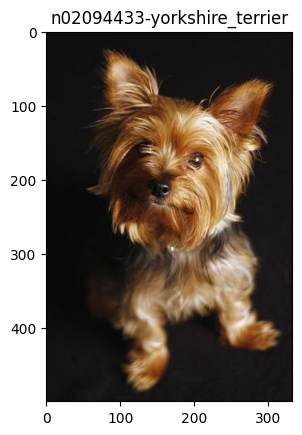

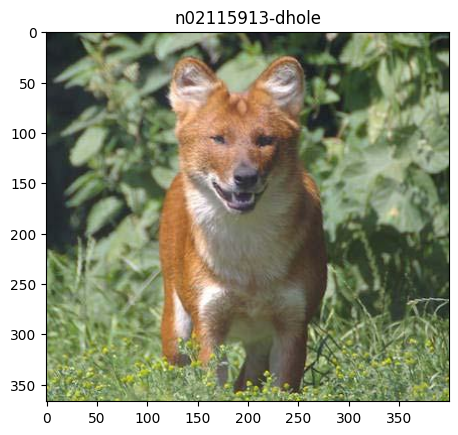

In [4]:
# show first 2 images & lable from training set
get_label_name = metadate.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [5]:
# resize all images to be 160x160
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [6]:
# resize all datasets
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [7]:
# shuffle & batch the data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
# inspect a batch of data
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [9]:
# create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
# feature extraction of each 160x160x3 image into a 5x5x1280 block of features
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
# freeze convolutional base
base_model.trainable = False

In [12]:
# convert features to a single 1280-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
# apply dense layer to convert these features into a single predication per image
prediction_layer = tf.keras.layers.Dense(120)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [14]:
# stack layers
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [15]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
# train model
initial_epochs = 10
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
300/300 [==============================] - 10s 28ms/step - loss: 3.7746 - accuracy: 0.2005 - val_loss: 2.6905 - val_accuracy: 0.4083
Epoch 2/10
300/300 [==============================] - 8s 26ms/step - loss: 1.9489 - accuracy: 0.6029 - val_loss: 1.6061 - val_accuracy: 0.6233
Epoch 3/10
300/300 [==============================] - 8s 26ms/step - loss: 1.2124 - accuracy: 0.7278 - val_loss: 1.1894 - val_accuracy: 0.6858
Epoch 4/10
300/300 [==============================] - 8s 26ms/step - loss: 0.9072 - accuracy: 0.7764 - val_loss: 0.9997 - val_accuracy: 0.7150
Epoch 5/10
300/300 [==============================] - 8s 26ms/step - loss: 0.7512 - accuracy: 0.8029 - val_loss: 0.8951 - val_accuracy: 0.7217
Epoch 6/10
300/300 [==============================] - 8s 26ms/step - loss: 0.6550 - accuracy: 0.8235 - val_loss: 0.8296 - val_accuracy: 0.7350
Epoch 7/10
300/300 [==============================] - 8s 26ms/step - loss: 0.5893 - accuracy: 0.8378 - val_loss: 0.7854 - val_accuracy: 0.740

In [17]:
# Evaluate the model
results = model.evaluate(test_batches, verbose=2)

38/38 - 1s - loss: 0.7525 - accuracy: 0.7533 - 837ms/epoch - 22ms/step


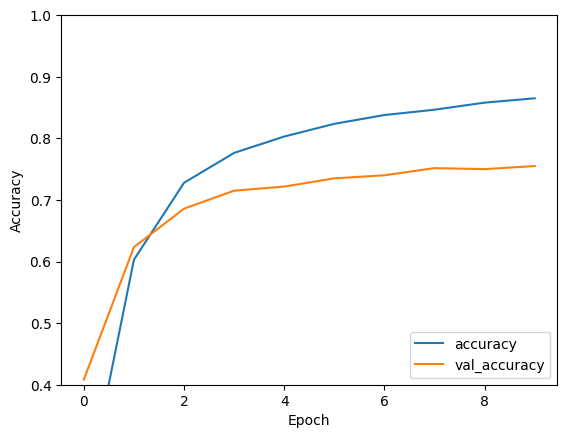

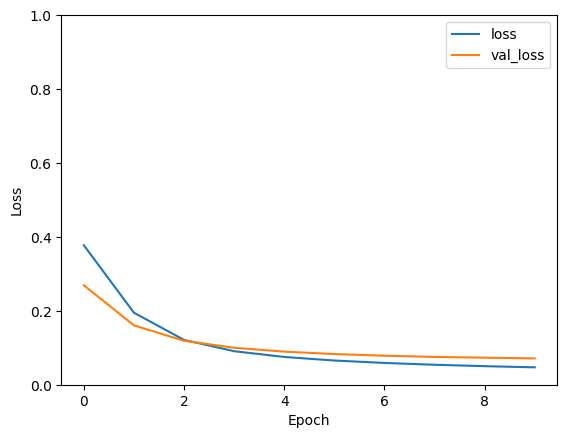

In [18]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

# Included loss to measure overfitting
# Note: loss & val_loss are x10 larger then expected. Don't know why. Divided both by 10.
plt.figure()
plt.plot(np.multiply(history.history['loss'], 0.1), label='loss')
plt.plot(np.multiply(history.history['val_loss'], 0.1), label = 'val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')